In [134]:
import gymnasium as gym
from bettermdptools.algorithms.planner import Planner
from bettermdptools.utils.plots import Plots
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from bettermdptools.utils.test_env import TestEnv
from tqdm import tqdm
import seaborn as sns

import pickle
import numpy as np
import pandas as pd
import random

from utils import *

np.random.seed(42)
random.seed(42)

%load_ext autoreload
%autoreload 2

SIZE = 8
map_size = (SIZE, SIZE)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Problem Init

In [2]:
# using numpy, generate a 20x20 grid of random numbers between 0 and 1 with P(1) = 0.3
np.random.seed(42)
map_size = (16, 16)
random_map = np.random.choice([0, 1], size=map_size, p=[0.85, 0.15])

# convert the numpy array to a list of lists by replacing 0s with 'F' and 1s with 'H'
random_map = random_map.tolist()
random_map = [[['F', 'H'][cell] for cell in row] for row in random_map]
random_map = [''.join(row) for row in random_map]
# add the start and goal states
random_map[0] = 'SF' + random_map[0][2:]
random_map[1] = 'F' + random_map[1][1:]
random_map[-1] = random_map[-1][:-1] + 'G'

In [3]:
frozen_lake_16 = gym.make('FrozenLake-v1', is_slippery=True, desc=random_map, max_episode_steps=400, render_mode="rgb_array")
frozen_lake_8 = gym.make('FrozenLake8x8-v1', is_slippery=True, render_mode="rgb_array")
frozen_lake_4 = gym.make('FrozenLake-v1', is_slippery=True, render_mode="rgb_array")

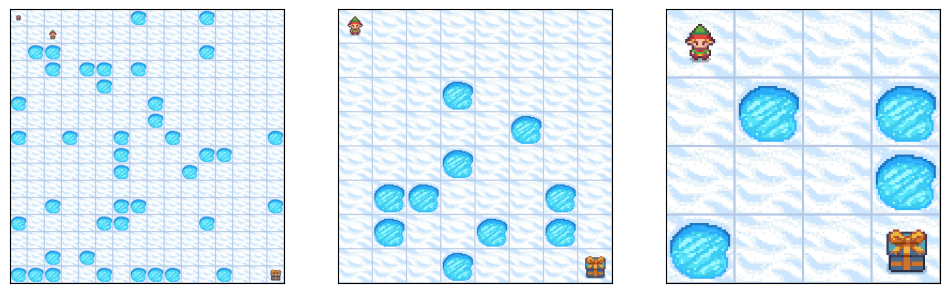

State space size: 256
Action space size: 4
State space size: 64
Action space size: 4
State space size: 16
Action space size: 4


In [4]:
# render the environment
frozen_lake_16.reset(seed=42, starting_state=18)
frozen_lake_8.reset(seed=42)
frozen_lake_4.reset(seed=42)

rgb_array_16 = frozen_lake_16.render()
rgb_array_8 = frozen_lake_8.render()
rgb_array_4 = frozen_lake_4.render()

# plot the environment
import matplotlib.pyplot as plt
# 2 x 1 grid
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

ax[0].imshow(rgb_array_16)
ax[0].grid(False)
ax[0].set_xticks([])
ax[0].set_yticks([])
# ax[0].set_title("Frozen Lake 8x8")

ax[1].imshow(rgb_array_8)
ax[1].grid(False)
ax[1].set_xticks([])
ax[1].set_yticks([])
# ax[1].set_title("Frozen Lake 4x4")

ax[2].imshow(rgb_array_4)
ax[2].grid(False)
ax[2].set_xticks([])
ax[2].set_yticks([])
# ax[2].set_title("Frozen Lake 4x4")


plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.savefig("figures/frozen_lake/frozen_lake_configs.pdf", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()


print("State space size:", frozen_lake_16.observation_space.n)
print("Action space size:", frozen_lake_16.action_space.n)

print("State space size:", frozen_lake_8.observation_space.n)
print("Action space size:", frozen_lake_8.action_space.n)

print("State space size:", frozen_lake_4.observation_space.n)
print("Action space size:", frozen_lake_4.action_space.n)

# Exploration strategies 

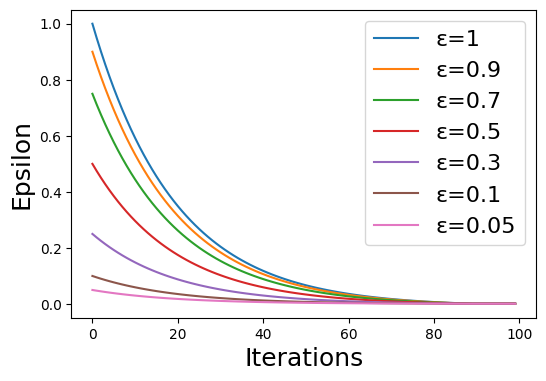

In [161]:
# create a figure with 2 subplots
plt.figure(figsize=(6,4))  
plt.style.use('default')

epsilons1 = RL(frozen_lake_16).decay_schedule(1.0, 0.001, 0.9, 100)
epsilons09 = RL(frozen_lake_16).decay_schedule(0.9, 0.001, 0.9, 100)
epsilons075 = RL(frozen_lake_16).decay_schedule(0.75, 0.001, 0.9, 100)
epsilons050 = RL(frozen_lake_16).decay_schedule(0.5, 0.001, 0.9, 100)
epsilons025 = RL(frozen_lake_16).decay_schedule(0.25, 0.001, 0.9, 100)
epsilons010 = RL(frozen_lake_16).decay_schedule(0.1, 0.001, 0.9, 100)
epsilons005 = RL(frozen_lake_16).decay_schedule(0.05, 0.001, 0.9, 100)
epsilons5 = RL(frozen_lake_16).decay_schedule(1.0, 0.001, 0.9, 100)
plt.plot(epsilons1, label="ε=1")
plt.plot(epsilons09, label="ε=0.9")
plt.plot(epsilons075, label="ε=0.7")
plt.plot(epsilons050, label="ε=0.5")
plt.plot(epsilons025, label="ε=0.3")
plt.plot(epsilons010, label="ε=0.1")
plt.plot(epsilons005, label="ε=0.05")
plt.xlabel("Iterations", fontsize=18)
plt.ylabel("Epsilon", fontsize=18)
plt.legend(fontsize=16)
# plt.savefig("figures/mountain_cart/epsilon_decay.pdf", format="pdf", bbox_inches="tight")

## 1. 4x4 Q-Learning

### Decayed epsilon

In [284]:
gs4 = {}

In [285]:
import time
for epsilon in [1, 0.9, 0.7, 0.5, 0.3, 0.1, 0.05]:
    start = time.time()
    Q, V, pi, Q_track, pi_track, rewards, endings, steps_per_episode = RL(frozen_lake_4).q_learning(
    gamma=.999,
    init_epsilon=epsilon,
    min_epsilon=0.001,
    epsilon_decay_ratio=0.9,
    n_episodes=10000,
    )
    duration = time.time() - start

    temp = {"Q":Q, "V":V, "pi":pi, "Q_track":Q_track, "pi_track":pi_track, "rewards":rewards, "endings":endings, "steps_per_episode":steps_per_episode, "duration": duration}
    gs4[epsilon] = temp

  0%|          | 0/10000 [00:00<?, ?it/s]

runtime = 3.85 seconds


runtime = 3.98 seconds


runtime = 4.20 seconds


runtime = 4.50 seconds


runtime = 5.28 seconds


runtime = 2.82 seconds


runtime = 2.43 seconds


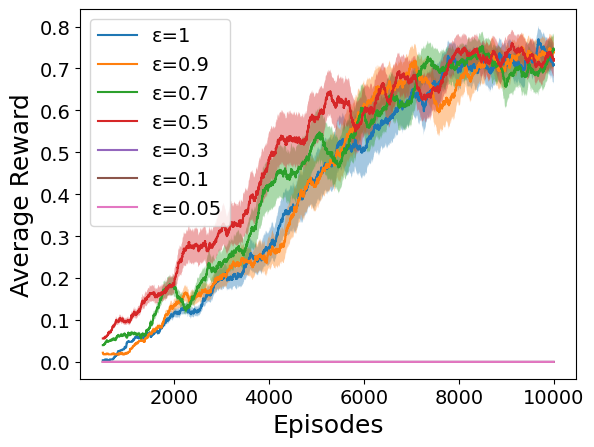

In [162]:
for epsilon in gs:
    # rolling mean of rewards
    rewards = pd.Series(gs[epsilon]['rewards'])
    rewards = rewards.rolling(window=500).mean()
    # do std
    rewards_std = pd.Series(gs[epsilon]['rewards'])
    rewards_std = rewards_std.rolling(window=500).std() ** 4

    plt.plot(rewards, label=f"ε={epsilon}")
    plt.fill_between(rewards.index, rewards - rewards_std, rewards + rewards_std, alpha=0.4)

plt.xlabel("Episodes", fontsize=18)
plt.ylabel("Average Reward", fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("figures/frozen_lake/QL/4_QL_decayed_epsilon_rewards.pdf", format="pdf", bbox_inches="tight")

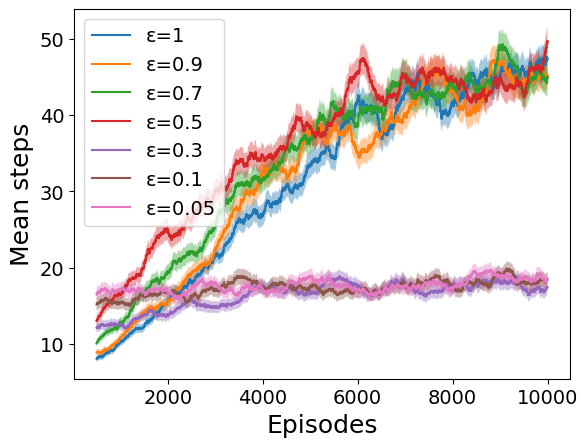

In [163]:
for epsilon in gs:
    # rolling mean of rewards
    rewards = pd.Series(gs[epsilon]['steps_per_episode'])
    rewards = rewards.rolling(window=500).mean()
    # do std
    rewards_std = pd.Series(gs[epsilon]['steps_per_episode'])
    rewards_std = rewards_std.rolling(window=500).std() / 15

    plt.plot(rewards, label=f"ε={epsilon}")
    plt.fill_between(rewards.index, rewards - rewards_std, rewards + rewards_std, alpha=0.4)

plt.xlabel("Episodes", fontsize=18)
plt.ylabel("Mean steps", fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("figures/frozen_lake/QL/4_QL_decayed_epsilon_steps.pdf", format="pdf", bbox_inches="tight")


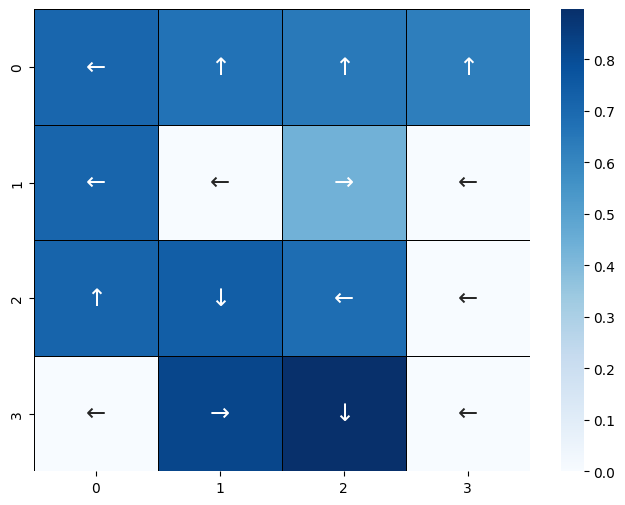

In [287]:
pi = gs4[0.5]['pi']
V = gs4[0.5]['V']
from bettermdptools.utils.plots import Plots
fl_actions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
fl_map_size=(4,4)
title=""
val_max, policy_map = Plots.get_policy_map(pi, V, fl_actions, fl_map_size)
Plots.plot_policy(val_max, policy_map, fl_map_size, title)

In [169]:
gs = {}

In [166]:
import time
for epsilon in [1, 0.9, 0.7, 0.5, 0.3, 0.1, 0.05]:
    start = time.time()
    Q, V, pi, Q_track, pi_track, rewards, endings, steps_per_episode = RL(frozen_lake_4).q_learning(
    gamma=.999,
    init_epsilon=1.0,
    min_epsilon=0.001,
    epsilon_decay_ratio=epsilon,
    n_episodes=10000,
    )
    duration = time.time() - start

    temp = {"Q":Q, "V":V, "pi":pi, "Q_track":Q_track, "pi_track":pi_track, "rewards":rewards, "endings":endings, "steps_per_episode":steps_per_episode, "duration": duration}
    gs[epsilon] = temp

 31%|███▏      | 3141/10000 [00:00<00:01, 4602.38it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


runtime = 3.78 seconds


runtime = 3.75 seconds


runtime = 4.03 seconds


runtime = 4.36 seconds


runtime = 4.87 seconds


runtime = 5.09 seconds


runtime = 2.39 seconds


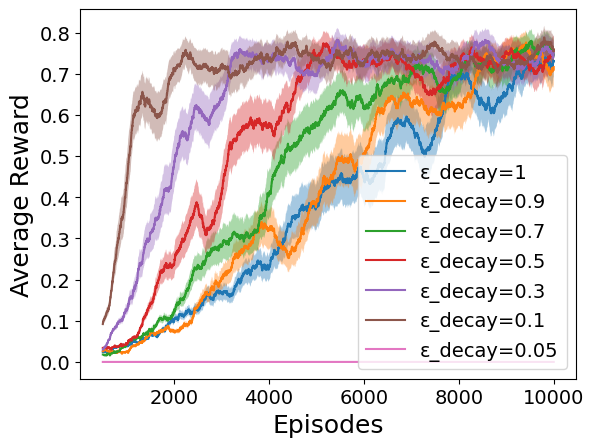

In [167]:
for epsilon in gs:
    # rolling mean of rewards
    rewards = pd.Series(gs[epsilon]['rewards'])
    rewards = rewards.rolling(window=500).mean()
    # do std
    rewards_std = pd.Series(gs[epsilon]['rewards'])
    rewards_std = rewards_std.rolling(window=500).std() ** 4

    plt.plot(rewards, label=f"ε_decay={epsilon}")
    plt.fill_between(rewards.index, rewards - rewards_std, rewards + rewards_std, alpha=0.4)

plt.xlabel("Episodes", fontsize=18)
plt.ylabel("Average Reward", fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("figures/frozen_lake/QL/4_QL_decayed_epsilon_decay_rewards.pdf", format="pdf", bbox_inches="tight")

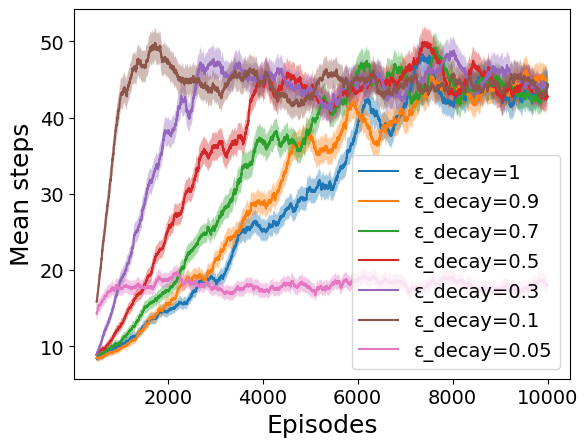

In [168]:
for epsilon in gs:
    # rolling mean of rewards
    rewards = pd.Series(gs[epsilon]['steps_per_episode'])
    rewards = rewards.rolling(window=500).mean()
    # do std
    rewards_std = pd.Series(gs[epsilon]['steps_per_episode'])
    rewards_std = rewards_std.rolling(window=500).std() / 15

    plt.plot(rewards, label=f"ε_decay={epsilon}")
    plt.fill_between(rewards.index, rewards - rewards_std, rewards + rewards_std, alpha=0.4)

plt.xlabel("Episodes", fontsize=18)
plt.ylabel("Mean steps", fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("figures/frozen_lake/QL/4_QL_decayed_epsilon_decay_steps.pdf", format="pdf", bbox_inches="tight")


### Fixed epsilon

In [171]:
gs = {}

import time
for epsilon in [1, 0.9, 0.7, 0.5, 0.3, 0.1, 0.05]:
    start = time.time()
    Q, V, pi, Q_track, pi_track, rewards, endings, steps_per_episode = RL(frozen_lake_4).q_learning(
    gamma=.999,
    init_epsilon=epsilon,
    min_epsilon=epsilon,
    epsilon_decay_ratio=0.9,
    n_episodes=10000,
    )
    duration = time.time() - start

    temp = {"Q":Q, "V":V, "pi":pi, "Q_track":Q_track, "pi_track":pi_track, "rewards":rewards, "endings":endings, "steps_per_episode":steps_per_episode, "duration": duration}
    gs[epsilon] = temp

runtime = 2.09 seconds


runtime = 2.13 seconds


runtime = 2.29 seconds


runtime = 2.66 seconds


 67%|██████▋   | 6687/10000 [00:02<00:01, 2984.21it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


runtime = 3.44 seconds


runtime = 2.82 seconds


runtime = 2.94 seconds


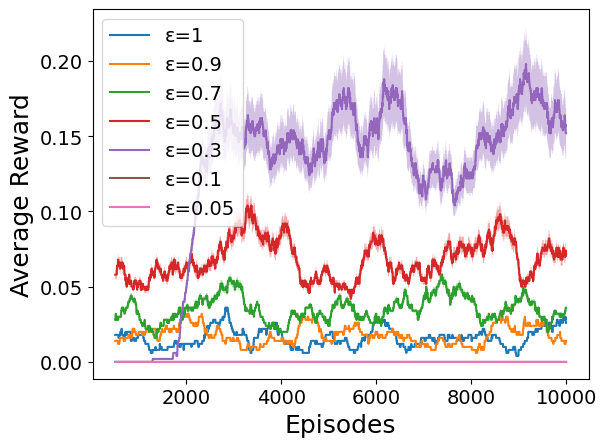

In [172]:
for epsilon in gs:
    # rolling mean of rewards
    rewards = pd.Series(gs[epsilon]['rewards'])
    rewards = rewards.rolling(window=500).mean()
    # do std
    rewards_std = pd.Series(gs[epsilon]['rewards'])
    rewards_std = rewards_std.rolling(window=500).std() ** 4

    plt.plot(rewards, label=f"ε={epsilon}")
    plt.fill_between(rewards.index, rewards - rewards_std, rewards + rewards_std, alpha=0.4)

plt.xlabel("Episodes", fontsize=18)
plt.ylabel("Average Reward", fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("figures/frozen_lake/QL/4_QL_no_decay_epsilon_rewards.pdf", format="pdf", bbox_inches="tight")

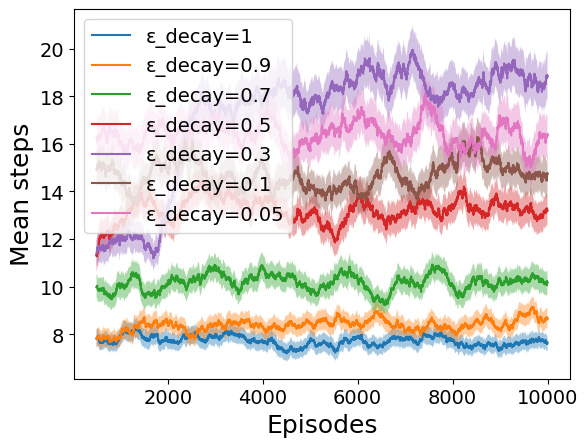

In [173]:
for epsilon in gs:
    # rolling mean of rewards
    rewards = pd.Series(gs[epsilon]['steps_per_episode'])
    rewards = rewards.rolling(window=500).mean()
    # do std
    rewards_std = pd.Series(gs[epsilon]['steps_per_episode'])
    rewards_std = rewards_std.rolling(window=500).std() / 15

    plt.plot(rewards, label=f"ε_decay={epsilon}")
    plt.fill_between(rewards.index, rewards - rewards_std, rewards + rewards_std, alpha=0.4)

plt.xlabel("Episodes", fontsize=18)
plt.ylabel("Mean steps", fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("figures/frozen_lake/QL/4_QL_no_decay_epsilon_steps.pdf", format="pdf", bbox_inches="tight")


## 2. 8x8 Q-Learning

In [174]:
frozen_lake_8 = gym.make('FrozenLake8x8-v1', is_slippery=True, render_mode="rgb_array")
gs = {}

In [178]:
import time
for epsilon in [1, 0.9, 0.7, 0.5, 0.3, 0.1, 0.05]:
    start = time.time()
    Q, V, pi, Q_track, pi_track, rewards, endings, steps_per_episode = RL(frozen_lake_8).q_learning(
    gamma=.999,
    init_epsilon=epsilon,
    min_epsilon=0.001,
    epsilon_decay_ratio=0.9,
    n_episodes=50000,
    )
    duration = time.time() - start

    temp = {"Q":Q, "V":V, "pi":pi, "Q_track":Q_track, "pi_track":pi_track, "rewards":rewards, "endings":endings, "steps_per_episode":steps_per_episode, "duration": duration}
    gs[epsilon] = temp

  0%|          | 0/50000 [00:00<?, ?it/s]

runtime = 74.15 seconds


runtime = 65.69 seconds


runtime = 97.07 seconds


runtime = 108.69 seconds


runtime = 111.99 seconds


runtime = 124.53 seconds


runtime = 141.18 seconds


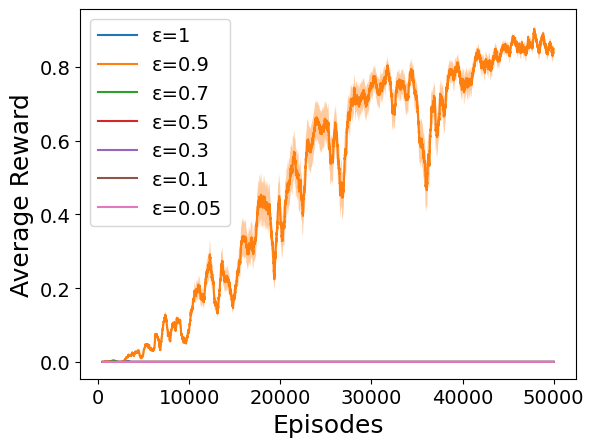

In [186]:
for epsilon in gs:
    # rolling mean of rewards
    rewards = pd.Series(gs[epsilon]['rewards'])
    rewards = rewards.rolling(window=500).mean()
    # do std
    rewards_std = pd.Series(gs[epsilon]['rewards'])
    rewards_std = rewards_std.rolling(window=500).std() ** 4

    plt.plot(rewards, label=f"ε={epsilon}")
    plt.fill_between(rewards.index, rewards - rewards_std, rewards + rewards_std, alpha=0.4)

plt.xlabel("Episodes", fontsize=18)
plt.ylabel("Average Reward", fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("figures/frozen_lake/QL/8_QL_decayed_epsilon_rewards.pdf", format="pdf", bbox_inches="tight")
plt.show()

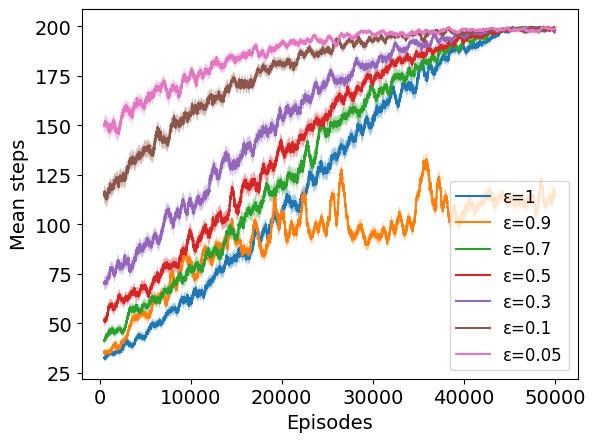

In [188]:
for epsilon in gs:
    # rolling mean of rewards
    rewards = pd.Series(gs[epsilon]['steps_per_episode'])
    rewards = rewards.rolling(window=500).mean()
    # do std
    rewards_std = pd.Series(gs[epsilon]['steps_per_episode'])
    rewards_std = rewards_std.rolling(window=500).std() / 15

    plt.plot(rewards, label=f"ε={epsilon}")
    plt.fill_between(rewards.index, rewards - rewards_std, rewards + rewards_std, alpha=0.4)

plt.xlabel("Episodes", fontsize=14)
plt.ylabel("Mean steps", fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("figures/frozen_lake/QL/8_QL_decayed_epsilon_steps.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [189]:
gsd = {}
import time
for epsilon in [1, 0.9, 0.7, 0.5, 0.3, 0.1, 0.05]:
    start = time.time()
    Q, V, pi, Q_track, pi_track, rewards, endings, steps_per_episode = RL(frozen_lake_8).q_learning(
    gamma=.999,
    init_epsilon=0.9,
    min_epsilon=0.001,
    epsilon_decay_ratio=epsilon,
    n_episodes=50000,
    )
    duration = time.time() - start

    temp = {"Q":Q, "V":V, "pi":pi, "Q_track":Q_track, "pi_track":pi_track, "rewards":rewards, "endings":endings, "steps_per_episode":steps_per_episode, "duration": duration}
    gsd[epsilon] = temp

  0%|          | 164/50000 [00:00<00:30, 1625.19it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


runtime = 52.29 seconds


runtime = 73.54 seconds


runtime = 100.14 seconds


runtime = 115.87 seconds


runtime = 121.42 seconds


runtime = 135.09 seconds


runtime = 135.79 seconds


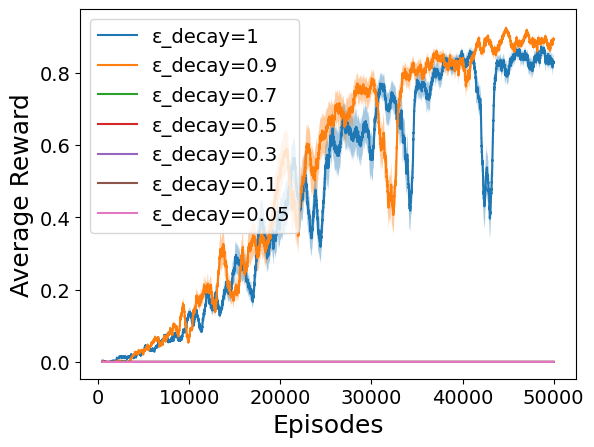

In [196]:
for epsilon in gsd:
    # rolling mean of rewards
    rewards = pd.Series(gsd[epsilon]['rewards'])
    rewards = rewards.rolling(window=500).mean()
    # do std
    rewards_std = pd.Series(gsd[epsilon]['rewards'])
    rewards_std = rewards_std.rolling(window=500).std() ** 4

    plt.plot(rewards, label=f"ε_decay={epsilon}")
    plt.fill_between(rewards.index, rewards - rewards_std, rewards + rewards_std, alpha=0.4)

plt.xlabel("Episodes", fontsize=18)
plt.ylabel("Average Reward", fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("figures/frozen_lake/QL/8_QL_decayed_epsilon_decay_rewards.pdf", format="pdf", bbox_inches="tight")
plt.show()

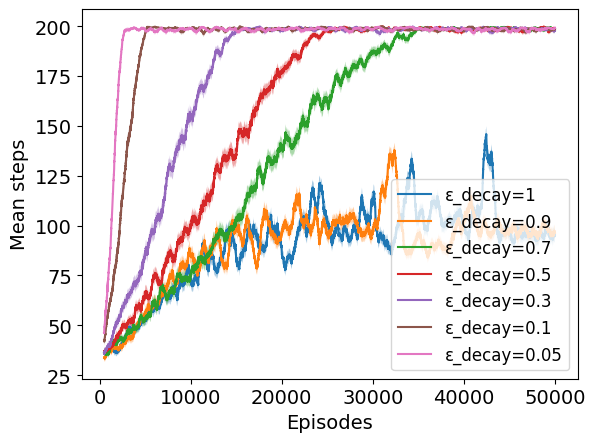

In [197]:
for epsilon in gsd:
    # rolling mean of rewards
    rewards = pd.Series(gsd[epsilon]['steps_per_episode'])
    rewards = rewards.rolling(window=500).mean()
    # do std
    rewards_std = pd.Series(gsd[epsilon]['steps_per_episode'])
    rewards_std = rewards_std.rolling(window=500).std() / 15

    plt.plot(rewards, label=f"ε_decay={epsilon}")
    plt.fill_between(rewards.index, rewards - rewards_std, rewards + rewards_std, alpha=0.4)

plt.xlabel("Episodes", fontsize=14)
plt.ylabel("Mean steps", fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("figures/frozen_lake/QL/8_QL_decayed_epsilon_decay_steps.pdf", format="pdf", bbox_inches="tight")
plt.show()

### negative reward

In [289]:
custom_rewards={b"G": 1, b"H": -1, b"F":0.0, b"S":0}
frozen_lake_8 = gym.make('FrozenLake8x8-v1', is_slippery=True, render_mode="rgb_array", custom_rewards=custom_rewards)
gs = {}

In [290]:
import time
for epsilon in [1, 0.9, 0.7, 0.5, 0.3, 0.1, 0.05]:
    start = time.time()
    Q, V, pi, Q_track, pi_track, rewards, endings, steps_per_episode = RL(frozen_lake_8).q_learning(
    gamma=.999,
    init_epsilon=epsilon,
    min_epsilon=0.001,
    epsilon_decay_ratio=0.9,
    n_episodes=10000,
    )
    duration = time.time() - start

    temp = {"Q":Q, "V":V, "pi":pi, "Q_track":Q_track, "pi_track":pi_track, "rewards":rewards, "endings":endings, "steps_per_episode":steps_per_episode, "duration": duration}
    gs[epsilon] = temp

  0%|          | 0/10000 [00:00<?, ?it/s]

/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


runtime = 10.52 seconds


runtime = 12.13 seconds


runtime = 11.29 seconds


runtime = 12.82 seconds


runtime = 12.24 seconds


runtime = 15.99 seconds


runtime = 23.15 seconds


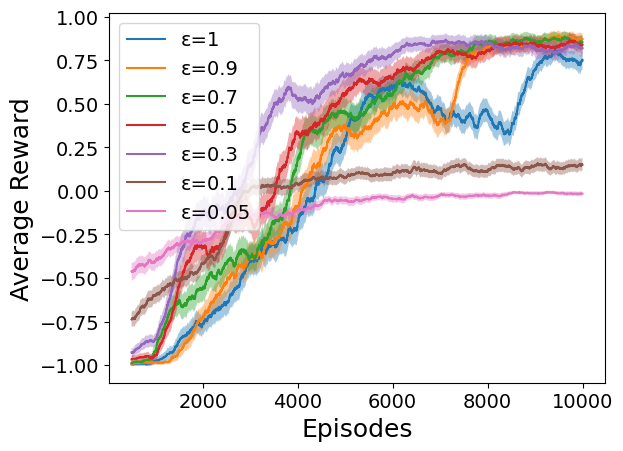

In [215]:
for epsilon in gs:
    # rolling mean of rewards
    rewards = pd.Series(gs[epsilon]['rewards'])
    rewards = rewards.rolling(window=500).mean()
    # do std
    rewards_std = pd.Series(gs[epsilon]['rewards'])
    rewards_std = rewards_std.rolling(window=500).std() / 10

    plt.plot(rewards, label=f"ε={epsilon}")
    plt.fill_between(rewards.index, rewards - rewards_std, rewards + rewards_std, alpha=0.4)

plt.xlabel("Episodes", fontsize=18)
plt.ylabel("Average Reward", fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("figures/frozen_lake/QL/8_QL_custom_rewards_decayed_epsilon_rewards.pdf", format="pdf", bbox_inches="tight")
plt.show()

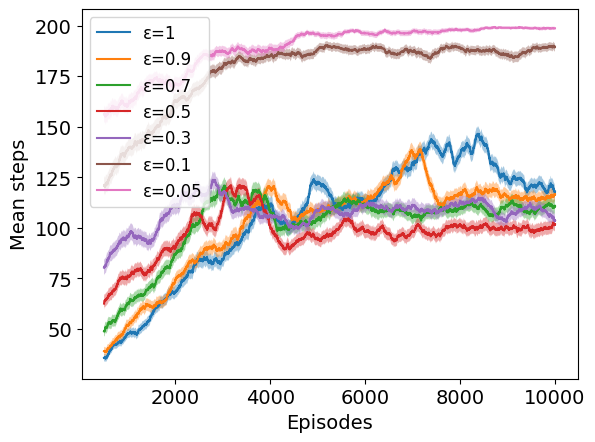

In [216]:
for epsilon in gs:
    # rolling mean of rewards
    rewards = pd.Series(gs[epsilon]['steps_per_episode'])
    rewards = rewards.rolling(window=500).mean()
    # do std
    rewards_std = pd.Series(gs[epsilon]['steps_per_episode'])
    rewards_std = rewards_std.rolling(window=500).std() / 15

    plt.plot(rewards, label=f"ε={epsilon}")
    plt.fill_between(rewards.index, rewards - rewards_std, rewards + rewards_std, alpha=0.4)

plt.xlabel("Episodes", fontsize=14)
plt.ylabel("Mean steps", fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("figures/frozen_lake/QL/8_QL_custom_rewards_decayed_epsilon_steps.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [291]:
for epsilon in gs:
    print("Epsilon:",epsilon)
    one_shot_eval(frozen_lake_8, gs[epsilon]["pi"], n_iters=1000)

Epsilon: 1
Success Rate: 87.8 %
Out of moves: 12.6 %
Fell in hole: 0.0 %
Mean run length:  113.766
Mean reward: 0.878
Epsilon: 0.9
Success Rate: 80.1 %
Out of moves: 19.8 %
Fell in hole: 0.9 %
Mean run length:  126.506
Mean reward: 0.792
Epsilon: 0.7
Success Rate: 88.7 %
Out of moves: 11.2 %
Fell in hole: 0.6 %
Mean run length:  110.518
Mean reward: 0.881
Epsilon: 0.5
Success Rate: 86.0 %
Out of moves: 13.5 %
Fell in hole: 0.9 %
Mean run length:  114.98
Mean reward: 0.851
Epsilon: 0.3
Success Rate: 86.1 %
Out of moves: 6.4 %
Fell in hole: 7.8 %
Mean run length:  100.861
Mean reward: 0.783
Epsilon: 0.1
Success Rate: 57.6 %
Out of moves: 29.2 %
Fell in hole: 13.5 %
Mean run length:  139.672
Mean reward: 0.441
Epsilon: 0.05
Success Rate: 0.0 %
Out of moves: 100.0 %
Fell in hole: 0.0 %
Mean run length:  200.0
Mean reward: 0.0


In [292]:
gsn = {}

In [293]:
import time
for epsilon in [1, 0.9, 0.7, 0.5, 0.3, 0.1, 0.05]:
    start = time.time()
    Q, V, pi, Q_track, pi_track, rewards, endings, steps_per_episode = RL(frozen_lake_8).q_learning(
    gamma=.999,
    init_epsilon=0.5,
    min_epsilon=0.001,
    epsilon_decay_ratio=epsilon,
    n_episodes=10000,
    )
    duration = time.time() - start

    temp = {"Q":Q, "V":V, "pi":pi, "Q_track":Q_track, "pi_track":pi_track, "rewards":rewards, "endings":endings, "steps_per_episode":steps_per_episode, "duration": duration}
    gsn[epsilon] = temp

runtime = 12.37 seconds


runtime = 12.37 seconds


runtime = 13.55 seconds


runtime = 13.01 seconds


runtime = 12.89 seconds


runtime = 22.40 seconds


runtime = 23.37 seconds


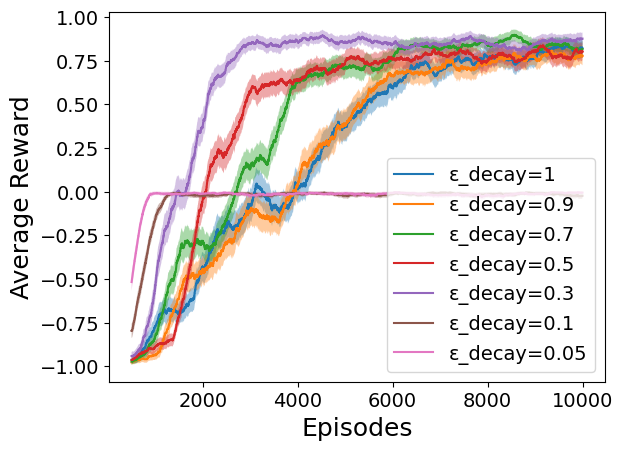

In [295]:
for epsilon in gsn:
    # rolling mean of rewards
    rewards = pd.Series(gsn[epsilon]['rewards'])
    rewards = rewards.rolling(window=500).mean()
    # do std
    rewards_std = pd.Series(gsn[epsilon]['rewards'])
    rewards_std = rewards_std.rolling(window=500).std() / 10

    plt.plot(rewards, label=f"ε_decay={epsilon}")
    plt.fill_between(rewards.index, rewards - rewards_std, rewards + rewards_std, alpha=0.4)

plt.xlabel("Episodes", fontsize=18)
plt.ylabel("Average Reward", fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("figures/frozen_lake/QL/8_QL_custom_rewards_decayed_epsilon_decay_rewards.pdf", format="pdf", bbox_inches="tight")
plt.show()

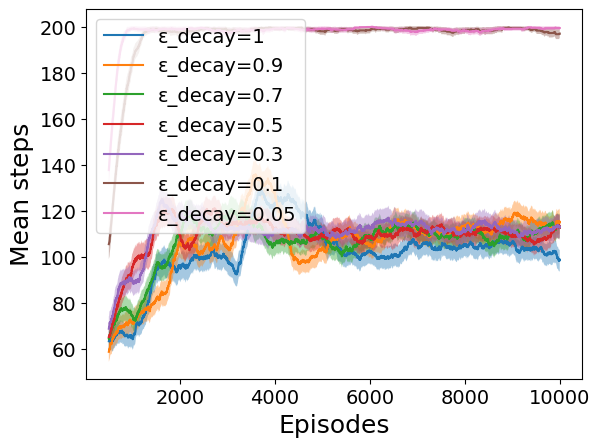

In [296]:
for epsilon in gsn:
    # rolling mean of rewards
    rewards = pd.Series(gsn[epsilon]['steps_per_episode'])
    rewards = rewards.rolling(window=500).mean()
    # do std
    rewards_std = pd.Series(gsn[epsilon]['steps_per_episode'])
    rewards_std = rewards_std.rolling(window=500).std() / 10

    plt.plot(rewards, label=f"ε_decay={epsilon}")
    plt.fill_between(rewards.index, rewards - rewards_std, rewards + rewards_std, alpha=0.4)

plt.xlabel("Episodes", fontsize=18)
plt.ylabel("Mean steps", fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("figures/frozen_lake/QL/8_QL_custom_rewards_decayed_epsilon_decay_steps.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [297]:
for epsilon in gsn:
    print("Epsilon:",epsilon)
    one_shot_eval(frozen_lake_8, gsn[epsilon]["pi"], n_iters=1000)

Epsilon: 1
Success Rate: 87.6 %
Out of moves: 8.9 %
Fell in hole: 3.9 %
Mean run length:  104.262
Mean reward: 0.837
Epsilon: 0.9
Success Rate: 84.7 %
Out of moves: 13.1 %
Fell in hole: 2.7 %
Mean run length:  112.253
Mean reward: 0.82
Epsilon: 0.7
Success Rate: 88.9 %
Out of moves: 7.9 %
Fell in hole: 3.5 %
Mean run length:  102.129
Mean reward: 0.854
Epsilon: 0.5
Success Rate: 84.1 %
Out of moves: 11.7 %
Fell in hole: 4.8 %
Mean run length:  110.473
Mean reward: 0.793
Epsilon: 0.3
Success Rate: 87.8 %
Out of moves: 11.9 %
Fell in hole: 0.6 %
Mean run length:  112.682
Mean reward: 0.872
Epsilon: 0.1
Success Rate: 0.0 %
Out of moves: 100.0 %
Fell in hole: 0.0 %
Mean run length:  200.0
Mean reward: 0.0
Epsilon: 0.05
Success Rate: 0.0 %
Out of moves: 100.0 %
Fell in hole: 0.0 %
Mean run length:  200.0
Mean reward: 0.0


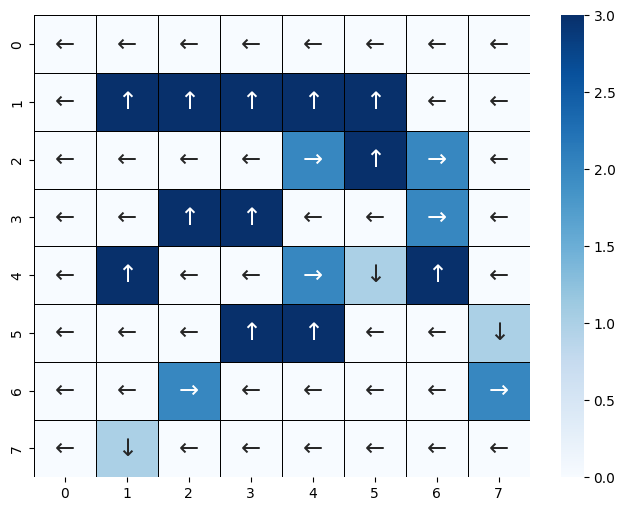

In [318]:
pi = {i: np.argmax(gsn[0.3]['Q_track'][500][i]) for i in range(64)}
V = gsn[0.3]['pi_track'][500]
from bettermdptools.utils.plots import Plots
fl_actions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
fl_map_size=(8,8)
title=""
val_max, policy_map = Plots.get_policy_map(pi, V, fl_actions, fl_map_size)
Plots.plot_policy(val_max, policy_map, fl_map_size, title)

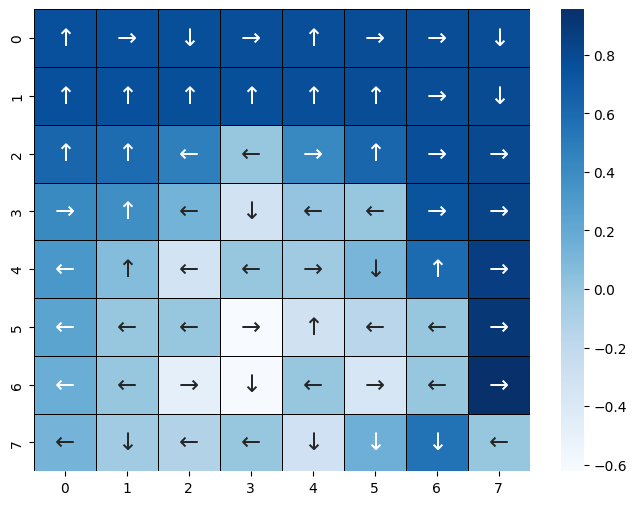

In [302]:
pi = gsn[0.7]['pi']
V = gsn[0.7]['V']
from bettermdptools.utils.plots import Plots
fl_actions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
fl_map_size=(8,8)
title=""
val_max, policy_map = Plots.get_policy_map(pi, V, fl_actions, fl_map_size)
Plots.plot_policy(val_max, policy_map, fl_map_size, title)

# 16x16 Q-Learning

In [243]:
custom_rewards={b"G": 1, b"H": -1, b"F":0.0, b"S":0}
frozen_lake_16 = gym.make('FrozenLake-v1', is_slippery=True, desc=random_map, max_episode_steps=400, render_mode="rgb_array", custom_rewards=custom_rewards)

In [244]:
import time
for epsilon in [1, 0.9, 0.7, 0.5, 0.3, 0.1, 0.05]:
    start = time.time()
    Q, V, pi, Q_track, pi_track, rewards, endings, steps_per_episode = RL(frozen_lake_16).q_learning(
    gamma=.999,
    init_epsilon=epsilon,
    min_epsilon=0.001,
    epsilon_decay_ratio=0.9,
    n_episodes=10000,
    )
    duration = time.time() - start

    temp = {"Q":Q, "V":V, "pi":pi, "Q_track":Q_track, "pi_track":pi_track, "rewards":rewards, "endings":endings, "steps_per_episode":steps_per_episode, "duration": duration}
    gs[epsilon] = temp

  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
 27%|██▋       | 2664/10000 [00:01<00:04, 1599.87it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


runtime = 29.38 seconds


runtime = 32.11 seconds


runtime = 34.06 seconds


runtime = 37.65 seconds


runtime = 49.73 seconds


runtime = 52.83 seconds


runtime = 54.88 seconds


In [251]:
plt.style.use('default')

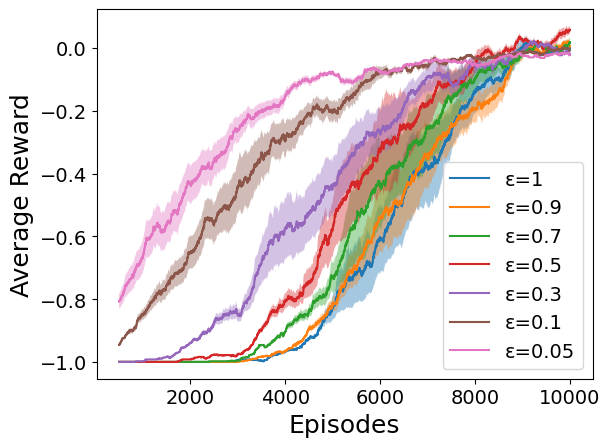

In [252]:
for epsilon in gs:
    # rolling mean of rewards
    rewards = pd.Series(gs[epsilon]['rewards'])
    rewards = rewards.rolling(window=500).mean()
    # do std
    rewards_std = pd.Series(gs[epsilon]['rewards'])
    rewards_std = rewards_std.rolling(window=500).std() ** 4

    plt.plot(rewards, label=f"ε={epsilon}")
    plt.fill_between(rewards.index, rewards - rewards_std, rewards + rewards_std, alpha=0.4)

plt.xlabel("Episodes", fontsize=18)
plt.ylabel("Average Reward", fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("figures/frozen_lake/QL/16_QL_decayed_epsilon_rewards.pdf", format="pdf", bbox_inches="tight")
plt.show()

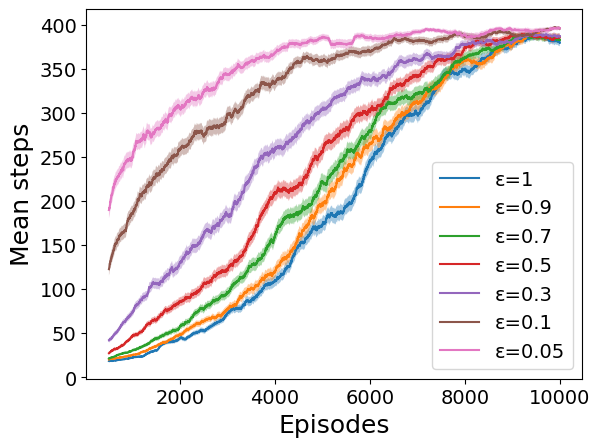

In [253]:
for epsilon in gs:
    # rolling mean of rewards
    rewards = pd.Series(gs[epsilon]['steps_per_episode'])
    rewards = rewards.rolling(window=500).mean()
    # do std
    rewards_std = pd.Series(gs[epsilon]['steps_per_episode'])
    rewards_std = rewards_std.rolling(window=500).std() / 15

    plt.plot(rewards, label=f"ε={epsilon}")
    plt.fill_between(rewards.index, rewards - rewards_std, rewards + rewards_std, alpha=0.4)

plt.xlabel("Episodes", fontsize=18)
plt.ylabel("Mean steps", fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("figures/frozen_lake/QL/16_QL_decayed_epsilon_steps.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [248]:
for epsilon in gs:
    one_shot_eval(frozen_lake_16, gs[epsilon]["pi"], n_iters=1000)

Success Rate: 7.3 %
Out of moves: 91.0 %
Fell in hole: 1.8 %
Mean run length:  389.138
Mean reward: 0.055
Success Rate: 3.2 %
Out of moves: 94.9 %
Fell in hole: 1.9 %
Mean run length:  393.384
Mean reward: 0.013
Success Rate: 12.0 %
Out of moves: 85.5 %
Fell in hole: 2.7 %
Mean run length:  382.788
Mean reward: 0.093
Success Rate: 6.1 %
Out of moves: 92.3 %
Fell in hole: 1.7 %
Mean run length:  390.041
Mean reward: 0.044
Success Rate: 3.5 %
Out of moves: 94.4 %
Fell in hole: 2.1 %
Mean run length:  393.263
Mean reward: 0.014
Success Rate: 1.3 %
Out of moves: 98.3 %
Fell in hole: 0.4 %
Mean run length:  398.155
Mean reward: 0.009
Success Rate: 0.6 %
Out of moves: 98.6 %
Fell in hole: 0.8 %
Mean run length:  397.866
Mean reward: -0.002


In [268]:
import time
for epsilon in [1, 0.9, 0.7, 0.5, 0.3, 0.1, 0.05]:
    start = time.time()
    Q, V, pi, Q_track, pi_track, rewards, endings, steps_per_episode = RL(frozen_lake_16).q_learning(
    gamma=.999,
    init_epsilon=epsilon,
    min_epsilon=0.001,
    epsilon_decay_ratio=0.9,
    n_episodes=50000,
    )
    duration = time.time() - start

    temp = {"Q":Q, "V":V, "pi":pi, "Q_track":Q_track, "pi_track":pi_track, "rewards":rewards, "endings":endings, "steps_per_episode":steps_per_episode, "duration": duration}
    gs[epsilon] = temp

  0%|          | 0/50000 [00:00<?, ?it/s]

runtime = 135.21 seconds


runtime = 149.09 seconds


runtime = 160.96 seconds


runtime = 178.44 seconds


runtime = 202.54 seconds


runtime = 158.99 seconds


runtime = 169.70 seconds


In [274]:
# save to pickle
with open("checkpoints/frozen_lake_50K_16x16.pickle", "wb") as f:
    pickle.dump(gs, f)


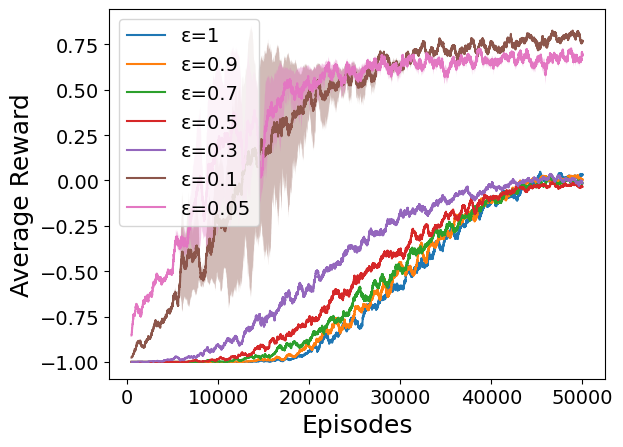

In [270]:
for epsilon in gs:
    # rolling mean of rewards
    rewards = pd.Series(gs[epsilon]['rewards'])
    rewards = rewards.rolling(window=500).mean()
    # do std
    rewards_std = pd.Series(gs[epsilon]['rewards'])
    rewards_std = rewards_std.rolling(window=500).std() ** 10

    plt.plot(rewards, label=f"ε={epsilon}")
    plt.fill_between(rewards.index, rewards - rewards_std, rewards + rewards_std, alpha=0.4)

plt.xlabel("Episodes", fontsize=18)
plt.ylabel("Average Reward", fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("figures/frozen_lake/QL/16_QL_50K_decayed_epsilon_rewards.pdf", format="pdf", bbox_inches="tight")
plt.show()

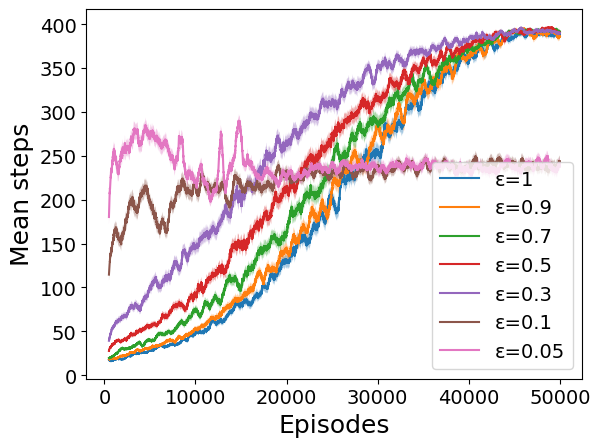

In [271]:
for epsilon in gs:
    # rolling mean of rewards
    rewards = pd.Series(gs[epsilon]['steps_per_episode'])
    rewards = rewards.rolling(window=500).mean()
    # do std
    rewards_std = pd.Series(gs[epsilon]['steps_per_episode'])
    rewards_std = rewards_std.rolling(window=500).std() / 15

    plt.plot(rewards, label=f"ε={epsilon}")
    plt.fill_between(rewards.index, rewards - rewards_std, rewards + rewards_std, alpha=0.4)

plt.xlabel("Episodes", fontsize=18)
plt.ylabel("Mean steps", fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.savefig("figures/frozen_lake/QL/16_QL_5OK_decayed_epsilon_steps.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [275]:
for epsilon in gs:
    print("Epsilon:",epsilon)
    one_shot_eval(frozen_lake_16, gs[epsilon]["pi"], n_iters=1000)

Epsilon: 1
Success Rate: 5.4 %
Out of moves: 94.5 %
Fell in hole: 0.2 %
Mean run length:  393.768
Mean reward: 0.052
Epsilon: 0.9
Success Rate: 4.9 %
Out of moves: 94.5 %
Fell in hole: 0.6 %
Mean run length:  394.283
Mean reward: 0.043
Epsilon: 0.7
Success Rate: 2.4 %
Out of moves: 96.3 %
Fell in hole: 1.3 %
Mean run length:  396.173
Mean reward: 0.011
Epsilon: 0.5
Success Rate: 1.0 %
Out of moves: 97.1 %
Fell in hole: 1.9 %
Mean run length:  397.118
Mean reward: -0.009
Epsilon: 0.3
Success Rate: 3.6 %
Out of moves: 96.3 %
Fell in hole: 0.1 %
Mean run length:  396.693
Mean reward: 0.035
Epsilon: 0.1
Success Rate: 83.2 %
Out of moves: 12.0 %
Fell in hole: 4.8 %
Mean run length:  238.707
Mean reward: 0.784
Epsilon: 0.05
Success Rate: 78.0 %
Out of moves: 12.1 %
Fell in hole: 10.0 %
Mean run length:  242.008
Mean reward: 0.68


In [276]:
del gs

## Use random starts

In [277]:
gsr ={}

In [319]:
import time
for epsilon in [1, 0.9, 0.7, 0.5, 0.3, 0.1, 0.05]:
    start = time.time()
    Q, V, pi, Q_track, pi_track, rewards, endings, steps_per_episode = RL(frozen_lake_16).q_learning(
    gamma=.999,
    init_epsilon=epsilon,
    min_epsilon=0.001,
    epsilon_decay_ratio=0.9,
    n_episodes=50000,
    random_start=True
    )
    duration = time.time() - start

    temp = {"Q":Q, "V":V, "pi":pi, "Q_track":Q_track, "pi_track":pi_track, "rewards":rewards, "endings":endings, "steps_per_episode":steps_per_episode, "duration": duration}
    gsr[epsilon] = temp

 33%|███▎      | 16547/50000 [00:08<00:27, 1222.38it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


runtime = 68.39 seconds


runtime = 70.74 seconds


runtime = 90.27 seconds


runtime = 117.33 seconds


runtime = 139.48 seconds


runtime = 127.70 seconds


runtime = 138.63 seconds


In [337]:
gsr[0.5]['Q_track'][1000]

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       ...,
       [-0.30816482, -0.48989283,  0.33815835, -0.4372443 ],
       [ 0.12219185,  0.76920985,  0.11010501,  0.57883104],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

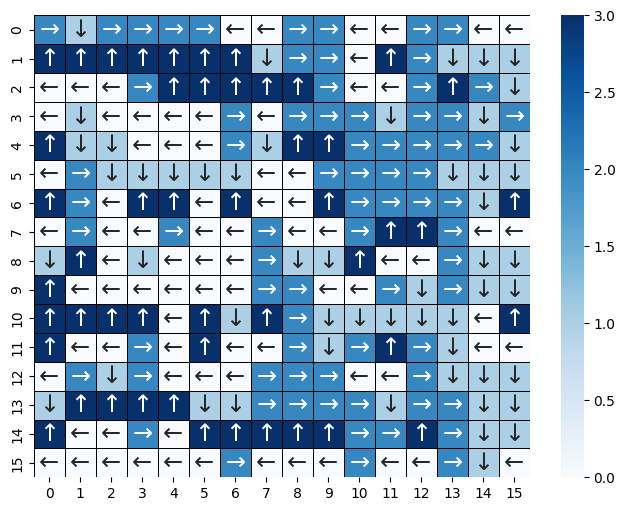

In [350]:
pi = {i: np.argmax(gsr[0.5]['Q_track'][-1][i]) for i in range(256)}
V = gsr[0.5]['pi_track'][-1]
from bettermdptools.utils.plots import Plots
fl_actions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
fl_map_size=(16,16)
title=""
val_max, policy_map = Plots.get_policy_map(pi, V, fl_actions, fl_map_size)
Plots.plot_policy(val_max, policy_map, fl_map_size, title)

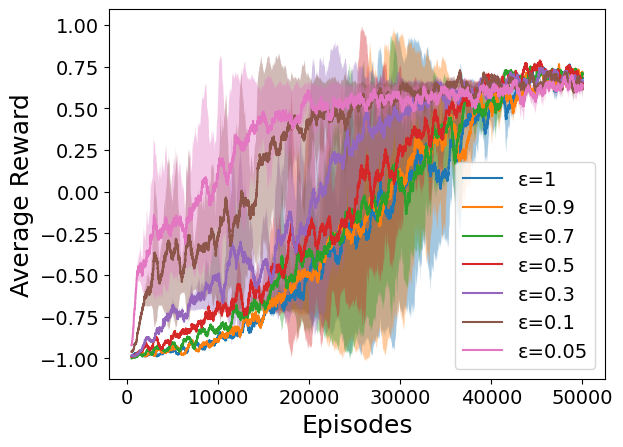

In [320]:
for epsilon in gsr:
    # rolling mean of rewards
    rewards = pd.Series(gsr[epsilon]['rewards'])
    rewards = rewards.rolling(window=500).mean()
    # do std
    rewards_std = pd.Series(gsr[epsilon]['rewards'])
    rewards_std = rewards_std.rolling(window=500).std() ** 10

    plt.plot(rewards, label=f"ε={epsilon}")
    plt.fill_between(rewards.index, rewards - rewards_std, rewards + rewards_std, alpha=0.4)

plt.xlabel("Episodes", fontsize=18)
plt.ylabel("Average Reward", fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.savefig("figures/frozen_lake/QL/16_QL_50K_decayed_epsilon_rewards.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [282]:
for epsilon in gsr:
    print("Epsilon:",epsilon)
    one_shot_eval(frozen_lake_16, gsr[epsilon]["pi"], n_iters=1000)

Epsilon: 1
Success Rate: 88.9 %
Out of moves: 3.4 %
Fell in hole: 7.7 %
Mean run length:  211.809
Mean reward: 0.812
Epsilon: 0.9
Success Rate: 89.6 %
Out of moves: 5.6 %
Fell in hole: 4.8 %
Mean run length:  223.151
Mean reward: 0.848
Epsilon: 0.7
Success Rate: 90.0 %
Out of moves: 4.2 %
Fell in hole: 5.8 %
Mean run length:  213.659
Mean reward: 0.842
Epsilon: 0.5
Success Rate: 91.2 %
Out of moves: 2.8 %
Fell in hole: 6.0 %
Mean run length:  200.935
Mean reward: 0.852
Epsilon: 0.3
Success Rate: 88.2 %
Out of moves: 7.8 %
Fell in hole: 4.1 %
Mean run length:  236.854
Mean reward: 0.841
Epsilon: 0.1
Success Rate: 84.8 %
Out of moves: 10.4 %
Fell in hole: 4.8 %
Mean run length:  243.378
Mean reward: 0.8
Epsilon: 0.05
Success Rate: 73.0 %
Out of moves: 21.4 %
Fell in hole: 5.7 %
Mean run length:  277.264
Mean reward: 0.673


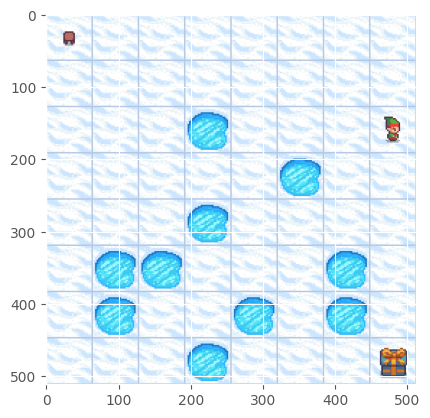

In [242]:
env = frozen_lake_8
pi = gsn[0.7]["pi"]


%matplotlib inline
plt.style.use('ggplot')
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

#  Let's see how the agent performs in the environment by running a single iteration of 1000 steps
# and rendering the environment at each step
env.reset()

img = plt.imshow(env.render())

for t in range(200):
    action = pi[env.s]
    img.set_data(env.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, b, c = env.step(action)
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        img.set_data(env.render())
        display.display(plt.gcf())
        break
        
env.close()